# Homework 4

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt



from skimage.feature import hog
from skimage import exposure

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

Для начала напишем функцию для загрузки наших данных (картинок и масок) и функции для отображения результатов.

In [3]:
def load_data(img_dir, mask_dir):
    target_size = (256, 256)
    if not os.path.exists(img_dir):
        raise FileNotFoundError(f'The {img_dir} directory does not exist.')
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f'The {mask_dir} directory does not exist.')
    images, masks = [], []
    image_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    if len(image_files) != len(mask_files):
        raise ValueError(f'The number of images ({len(image_files)}) and the number of masks ({len(mask_files)}) must match.')
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(img_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        image, mask = cv2.imread(img_path), cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        images.append(resized_image)
        masks.append(resized_mask)
    return images, masks


def plot(image, tail, normalized_tail, ind):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.axis('off')
    if tail is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(tail, cv2.COLOR_BGR2RGB))
        plt.title('Normalized tail')
        plt.axis('off')
    else:
        plt.subplot(1, 3, 2)
        plt.title('Normalized tail (None)')
        plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(normalized_tail, cv2.COLOR_BGR2RGB))
    plt.title('Normalized tail mask')
    plt.axis('off')
    plt.suptitle(f'Image {ind + 1}')
    plt.show()

Напишем вспомогательные функции для основной функции *normalize_tail_and_predict* для нормировки вырезанного хвоста и его маски.

In [4]:
def get_max_contour(contours):
    return max(contours, key=cv2.contourArea)

def get_transformation_matrix(src_pts, target_size):
    dst_pts = np.array([
        [0, target_size[1]], 
        [0, 0], 
        [target_size[0], 0], 
        [target_size[0], target_size[1]]
    ], dtype="float32")
    return cv2.getPerspectiveTransform(src_pts, dst_pts)

def warp_images(image, mask, transform, target_size):
    return cv2.warpPerspective(image, transform, target_size), cv2.warpPerspective(mask, transform, target_size)

def normalize_tail_and_predict(image, mask, target_size=(256, 256)):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    min_rectangle = cv2.minAreaRect(get_max_contour(contours))
    box_pts = np.intc(cv2.boxPoints(min_rectangle))
    src_pts = np.array(box_pts, dtype="float32")
    transform = get_transformation_matrix(src_pts, target_size)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    tail, pred_mask = warp_images(masked_image, mask, transform, target_size)
    return tail, pred_mask

Загрузим картинки и маски, и для каждой картинки вырежем хвост, нормируем его, посчитаем IoU и отобразим.

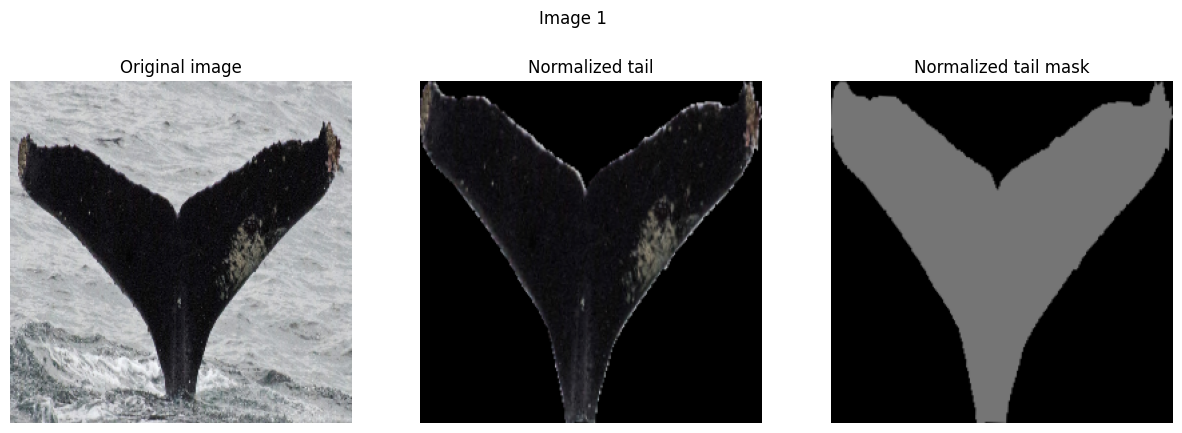

IoU for image 1 is 0.6616137256253014


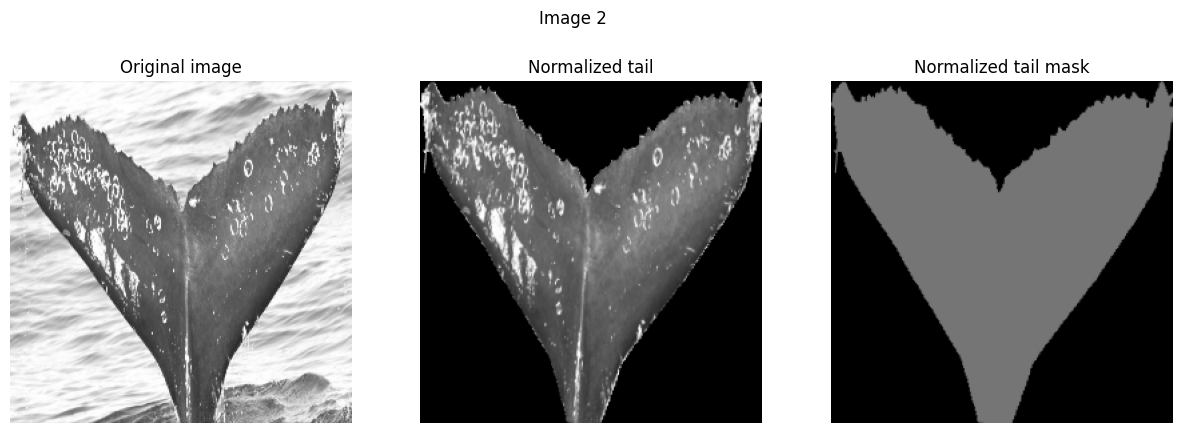

IoU for image 2 is 0.7984549752104232


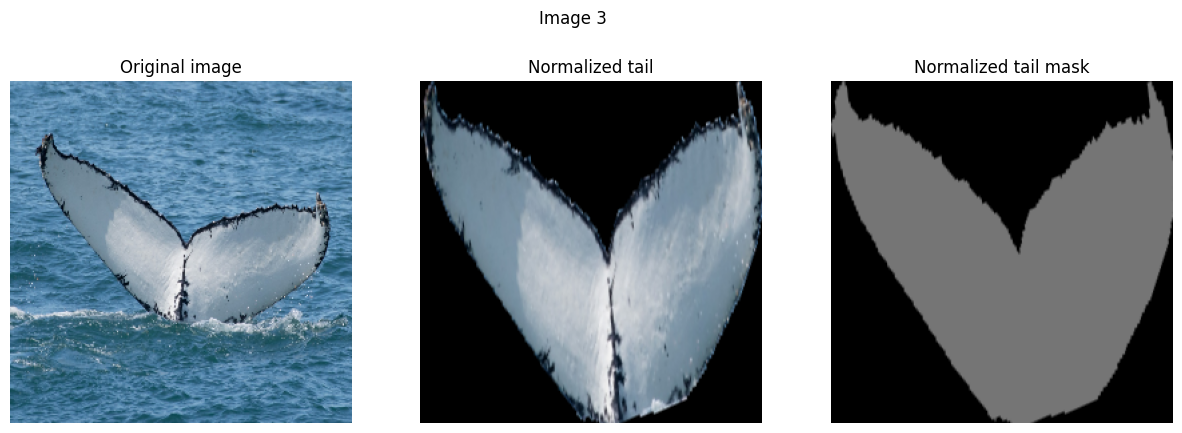

IoU for image 3 is 0.3931166347992352


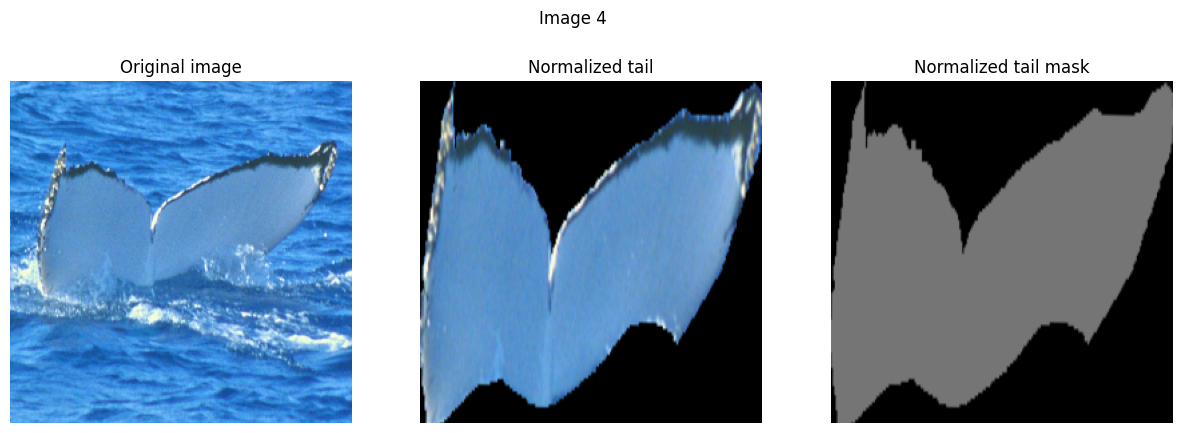

IoU for image 4 is 0.3630772358756703


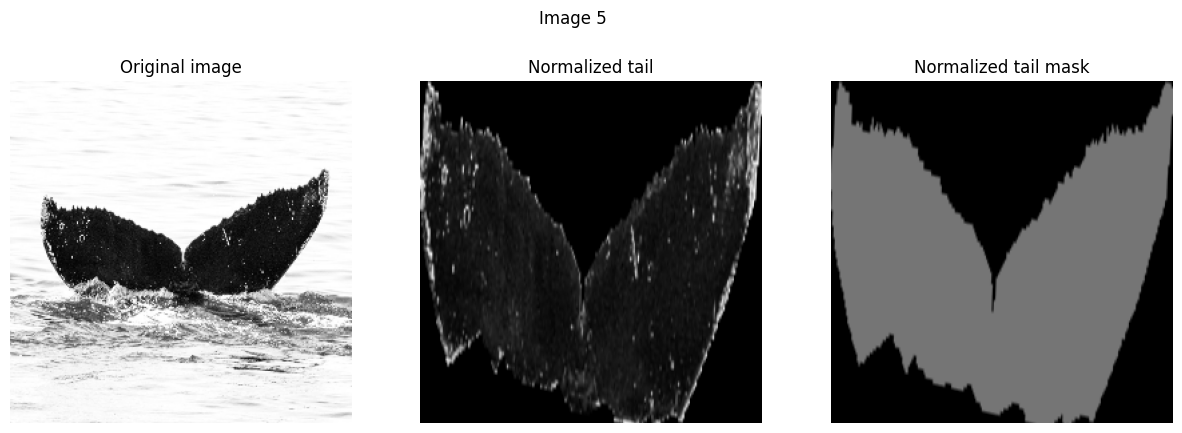

IoU for image 5 is 0.2735103544657604


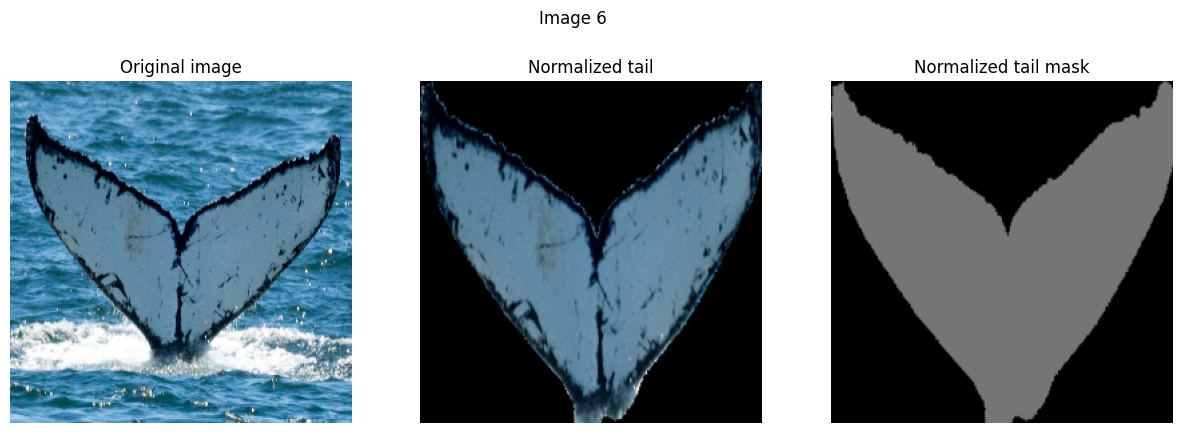

IoU for image 6 is 0.6325505924134341


In [10]:
image_dir = 'whale_tail/images'
mask_dir = 'whale_tail/ground_truth'
images, masks = load_data(image_dir, mask_dir)
for i, (image, mask) in enumerate(zip(images, masks)):
    iou_score = -1
    if mask is None:
        iou_score = 0
        continue
    processed_image, pred_mask = normalize_tail_and_predict(image, mask)
    if i in [0, 1, 3, 4]:
        processed_image = cv2.rotate(processed_image, cv2.ROTATE_90_CLOCKWISE)
        pred_mask = cv2.rotate(pred_mask, cv2.ROTATE_90_CLOCKWISE)
    if iou_score == -1:
        pred_mask_binary, true_mask_binary = pred_mask > 0, mask > 0
        intersection = np.logical_and(pred_mask_binary, true_mask_binary).sum()
        union = np.logical_or(pred_mask_binary, true_mask_binary).sum()  
        iou_score = intersection / union if union != 0 else 0
    plot(image, processed_image, pred_mask, i)
    print(f'IoU for image {i + 1} is {iou_score}')

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

Напишем функции для подсчета HOG признаков, поиск шаблона с помощью кросс-корреляции и отображения изображений.

In [6]:
def compute_hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, hog_image = hog(gray_image, orientations=9, pixels_per_cell=pixels_per_cell, 
                         cells_per_block=cells_per_block, visualize=visualize)
    return exposure.rescale_intensity(hog_image, in_range=(0, 10))

def detect_eye(hog_image, hog_template):
    hog_image, hog_template = np.float32(hog_image), np.float32(hog_template)
    result = cv2.matchTemplate(hog_image, hog_template, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    return max_loc, max_val

def plot_eyes(image, template, max_loc, max_val, hog_image=None):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original image')
    plt.axis('off')
    if tail is not None:
        plt.subplot(1, 3, 2)
        plt.imshow(hog_image, cmap='gray')
        plt.title('HOG signs')
        plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.title('Original template')
    plt.axis('off')
    h, w = template.shape[:2]
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Found template with accuracy {max_val:.2f}')
    plt.show()

Загрузим имеющийся шаблон и картинки, и для каждой картинки посчитаем HOG, а также выведим результат поиск шаблона в картинках.

NameError: name 'tail' is not defined

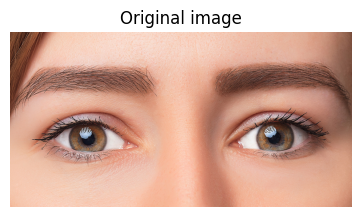

In [7]:
template_path = 'hog/eye.png'
images_path = ['hog/eyes.jpg', 'hog/eyes_dark.jpg', 'hog/woman.jpg']
template = cv2.imread(template_path)
w, h = int(template.shape[1] * 0.9), int(template.shape[0] * 0.9)
template_resized = cv2.resize(template, (w, h))
hog_template = compute_hog(template_resized, visualize=True)
for image_path in images_path:
    image = cv2.imread(image_path)
    hog_image = compute_hog(image, visualize=True)
    max_loc, max_val = detect_eye(hog_image, hog_template)
    plot_eyes(image, template_resized, max_loc, max_val, hog_image=hog_image)